In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("seroshkarim/cotton-leaf-disease-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/cotton-leaf-disease-dataset


In [8]:
import os, shutil, random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2, EfficientNetB3
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import zipfile

base_dir = "/kaggle/input/cotton-leaf-disease-dataset/cotton"
work_dir = "/kaggle/working/cotton_split"

# Remove old split if exists
if os.path.exists(work_dir):
    shutil.rmtree(work_dir)

train_dir = os.path.join(work_dir, "train")
val_dir   = os.path.join(work_dir, "validation")

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Train/validation split ratio
split_ratio = 0.8  

for cls in os.listdir(base_dir):
    cls_path = os.path.join(base_dir, cls)
    if not os.path.isdir(cls_path): 
        continue
    
    images = os.listdir(cls_path)
    random.shuffle(images)
    split = int(len(images) * split_ratio)

    train_cls_dir = os.path.join(train_dir, cls)
    val_cls_dir = os.path.join(val_dir, cls)
    os.makedirs(train_cls_dir, exist_ok=True)
    os.makedirs(val_cls_dir, exist_ok=True)

    # Copy files
    for img in images[:split]:
        shutil.copy(os.path.join(cls_path, img), os.path.join(train_cls_dir, img))
    for img in images[split:]:
        shutil.copy(os.path.join(cls_path, img), os.path.join(val_cls_dir, img))

print("✅ Train/Validation split created:")
print("Train classes:", os.listdir(train_dir))
print("Validation classes:", os.listdir(val_dir))

✅ Train/Validation split created:
Train classes: ['curl_virus', 'fussarium_wilt', 'bacterial_blight', 'healthy']
Validation classes: ['curl_virus', 'fussarium_wilt', 'bacterial_blight', 'healthy']


In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = (224,224)
batch_size = 32

train_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    train_dir, target_size=img_size, batch_size=batch_size, class_mode="categorical"
)
val_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    val_dir, target_size=img_size, batch_size=batch_size, class_mode="categorical", shuffle=False
)

class_names = list(train_gen.class_indices.keys())
print("✅ Classes:", class_names)


Found 1365 images belonging to 4 classes.
Found 344 images belonging to 4 classes.
✅ Classes: ['bacterial_blight', 'curl_virus', 'fussarium_wilt', 'healthy']


In [10]:
cnn_model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')
])

cnn_model.compile(optimizer=Adam(learning_rate=0.001), 
                  loss="categorical_crossentropy", 
                  metrics=["accuracy"])

early_stop = EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True)

history_cnn = cnn_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,   
    callbacks=[early_stop],
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


I0000 00:00:1756657286.110586     117 service.cc:148] XLA service 0x7e1018003790 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756657286.111333     117 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1756657286.111363     117 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1756657286.404835     117 cuda_dnn.cc:529] Loaded cuDNN version 90300


 3/43 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.3299 - loss: 3.4421

I0000 00:00:1756657292.468003     117 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


43/43 ━━━━━━━━━━━━━━━━━━━━ 22s 318ms/step - accuracy: 0.3332 - loss: 2.1821 - val_accuracy: 0.6076 - val_loss: 0.9609
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 0.6184 - loss: 0.8806 - val_accuracy: 0.7093 - val_loss: 0.7618
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 0.7241 - loss: 0.7176 - val_accuracy: 0.7674 - val_loss: 0.6386
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 0.8236 - loss: 0.4943 - val_accuracy: 0.8052 - val_loss: 0.5036
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 0.8639 - loss: 0.3933 - val_accuracy: 0.8547 - val_loss: 0.4824
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 0.8952 - loss: 0.3019 - val_accuracy: 0.9070 - val_loss: 0.3573
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 0.9473 - loss: 0.1701 - val_accuracy: 0.9041 - val_loss: 0.3325
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 0.9454 - loss: 0.1655 - val_accuracy: 0.8779 - val

In [11]:
base_model = MobileNetV2(input_shape=(224,224,3), include_top=False, weights='imagenet')
base_model.trainable = False

mobilenet_model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')
])

mobilenet_model.compile(optimizer=Adam(learning_rate=5e-4), 
                        loss="categorical_crossentropy", 
                        metrics=["accuracy"])

history_mobilenet = mobilenet_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=[early_stop],
    verbose=1
)

# fine-tune
base_model.trainable = True
mobilenet_model.compile(optimizer=Adam(learning_rate=1e-5), 
                        loss="categorical_crossentropy", 
                        metrics=["accuracy"])

history_mobilenet_ft = mobilenet_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=40,
    callbacks=[early_stop],
    verbose=1
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 27s 395ms/step - accuracy: 0.5955 - loss: 1.0729 - val_accuracy: 0.9244 - val_loss: 0.2660
Epoch 2/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 0.9277 - loss: 0.2347 - val_accuracy: 0.9448 - val_loss: 0.1472
Epoch 3/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9603 - loss: 0.1346 - val_accuracy: 0.9651 - val_loss: 0.1138
Epoch 4/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - accuracy: 0.9795 - loss: 0.0714 - val_accuracy: 0.9767 - val_loss: 0.0857
Epoch 5/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 0.9831 - loss: 0.0585 - val_accuracy: 0.9767 - val_loss: 0.0864
Epoch 6/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 0.9945 - loss: 0.0354 - val_accuracy: 0.9709 - val_loss: 0.0763
Epoch 7/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 0.9970 - loss: 0.0246 - val_accuracy: 0.9797 - val_loss: 0.0533
Epoch 8/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - 

In [12]:
eff_base = EfficientNetB3(input_shape=(224,224,3), include_top=False, weights='imagenet')
eff_base.trainable = False

x = eff_base.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
output = Dense(len(class_names), activation="softmax")(x)

eff_model = Model(inputs=eff_base.input, outputs=output)

eff_model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])

history_eff = eff_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=[early_stop],
    verbose=1
)

# fine-tune
eff_base.trainable = True
eff_model.compile(optimizer=Adam(learning_rate=1e-5), 
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])

history_eff_ft = eff_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=40,
    callbacks=[early_stop],
    verbose=1
)

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 81s 942ms/step - accuracy: 0.2600 - loss: 1.4011 - val_accuracy: 0.2616 - val_loss: 1.3818
Epoch 2/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - accuracy: 0.2763 - loss: 1.3907 - val_accuracy: 0.4041 - val_loss: 1.3755
Epoch 3/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 0.2592 - loss: 1.3964 - val_accuracy: 0.4360 - val_loss: 1.3702
Epoch 4/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - accuracy: 0.2631 - loss: 1.3934 - val_accuracy: 0.3750 - val_loss: 1.3651
Epoch 5/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 0.2717 - loss: 1.3851 - val_accuracy: 0.3924 - val_loss: 1.3600
Epoch 6/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 0.2819 - loss: 1.3766 - val_accuracy: 0.3634 - val_loss: 1.3550
Epoch 7/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.2838 - loss: 1.3865 - val_accuracy: 0.3924 - val_loss: 1.3512
Epoch 8/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step 

E0000 00:00:1756658501.895531     116 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1756658502.042916     116 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1756658502.654815     116 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1756658502.800854     116 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


27/43 ━━━━━━━━━━━━━━━━━━━━ 4s 297ms/step - accuracy: 0.2988 - loss: 1.4242

E0000 00:00:1756658558.963361     117 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1756658559.107582     117 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1756658559.525927     117 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1756658559.673198     117 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


43/43 ━━━━━━━━━━━━━━━━━━━━ 214s 2s/step - accuracy: 0.3122 - loss: 1.4089 - val_accuracy: 0.3023 - val_loss: 1.3694
Epoch 2/40
43/43 ━━━━━━━━━━━━━━━━━━━━ 16s 360ms/step - accuracy: 0.4891 - loss: 1.1668 - val_accuracy: 0.3227 - val_loss: 1.3698
Epoch 3/40
43/43 ━━━━━━━━━━━━━━━━━━━━ 15s 347ms/step - accuracy: 0.6753 - loss: 0.9632 - val_accuracy: 0.2558 - val_loss: 1.4213
Epoch 4/40
43/43 ━━━━━━━━━━━━━━━━━━━━ 14s 334ms/step - accuracy: 0.7606 - loss: 0.8171 - val_accuracy: 0.2791 - val_loss: 1.3716
Epoch 5/40
43/43 ━━━━━━━━━━━━━━━━━━━━ 14s 327ms/step - accuracy: 0.8174 - loss: 0.6863 - val_accuracy: 0.2703 - val_loss: 1.4303
Epoch 6/40
43/43 ━━━━━━━━━━━━━━━━━━━━ 14s 325ms/step - accuracy: 0.8736 - loss: 0.5485 - val_accuracy: 0.2645 - val_loss: 1.5061
Epoch 7/40
43/43 ━━━━━━━━━━━━━━━━━━━━ 14s 327ms/step - accuracy: 0.9054 - loss: 0.4473 - val_accuracy: 0.3081 - val_loss: 1.4671
Epoch 8/40
43/43 ━━━━━━━━━━━━━━━━━━━━ 15s 339ms/step - accuracy: 0.9267 - loss: 0.3883 - val_accuracy: 0.3866 

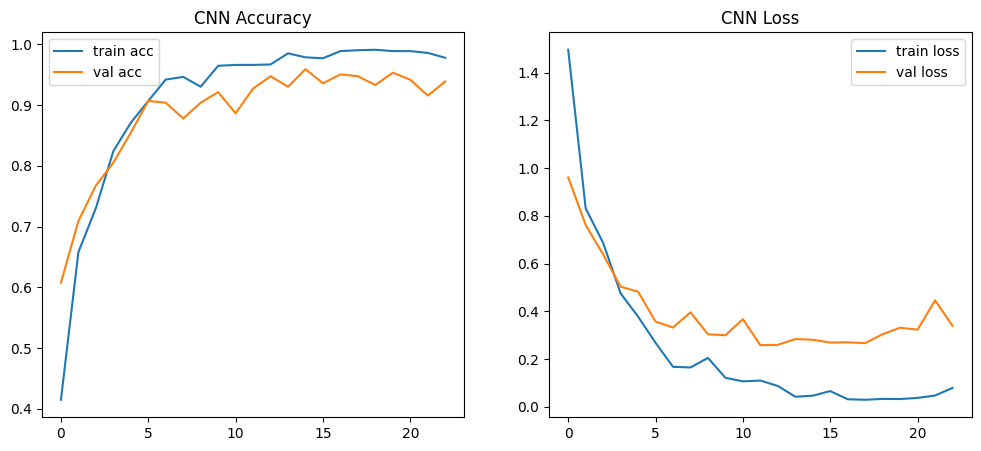

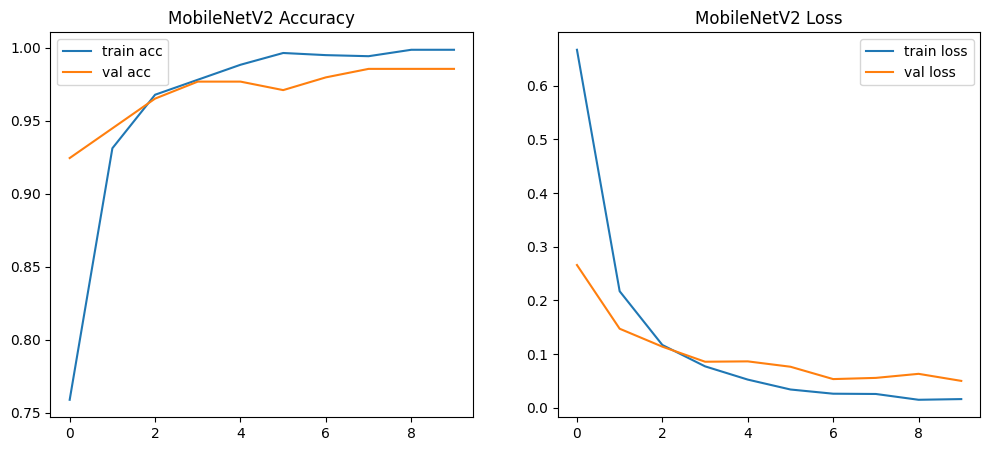

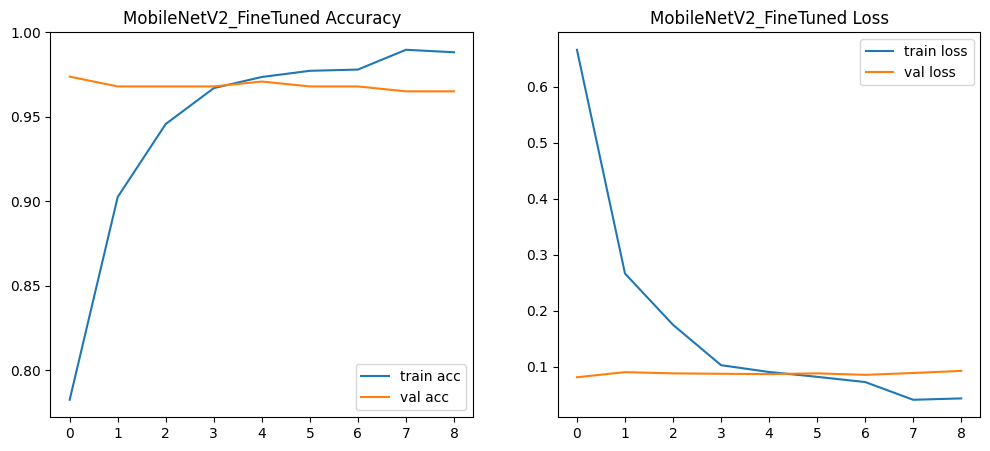

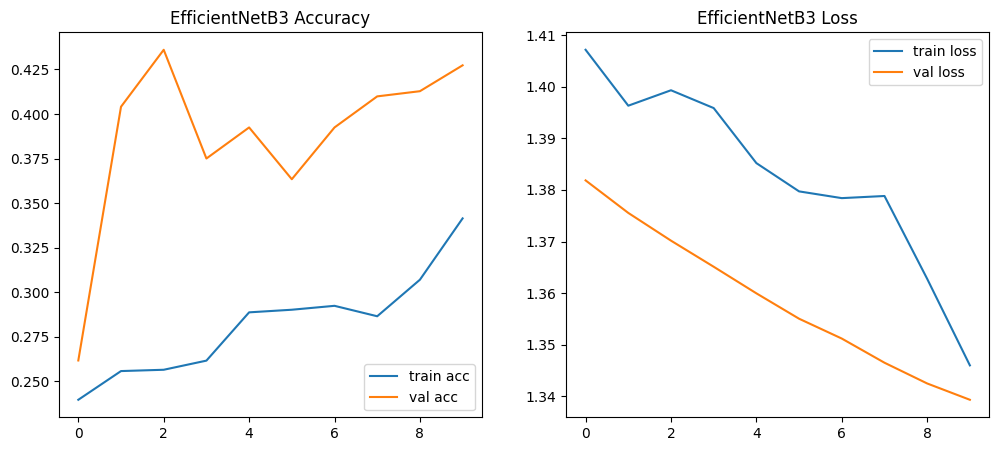

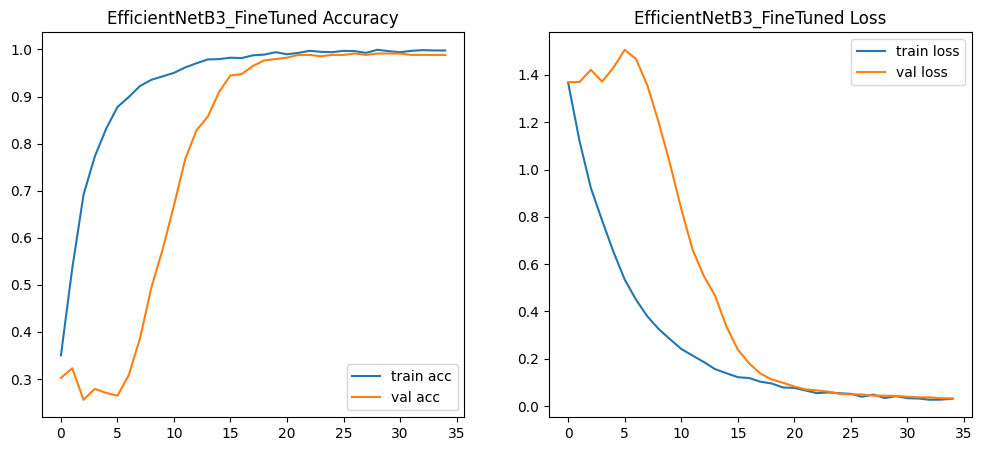

In [13]:
# =============================
# CELL 4: Plot Accuracy/Loss Graphs
# =============================
def plot_history(histories, names):
    for h, name in zip(histories, names):
        plt.figure(figsize=(12,5))

        # Accuracy
        plt.subplot(1,2,1)
        plt.plot(h.history['accuracy'], label='train acc')
        plt.plot(h.history['val_accuracy'], label='val acc')
        plt.title(f"{name} Accuracy")
        plt.legend()

        # Loss
        plt.subplot(1,2,2)
        plt.plot(h.history['loss'], label='train loss')
        plt.plot(h.history['val_loss'], label='val loss')
        plt.title(f"{name} Loss")
        plt.legend()

        # Save each graph as PNG
        plt.savefig(f"{name}_training.png")
        plt.show()

plot_history(
    [history_cnn, history_mobilenet, history_mobilenet_ft, history_eff, history_eff_ft],
    ["CNN", "MobileNetV2", "MobileNetV2_FineTuned", "EfficientNetB3", "EfficientNetB3_FineTuned"]
)


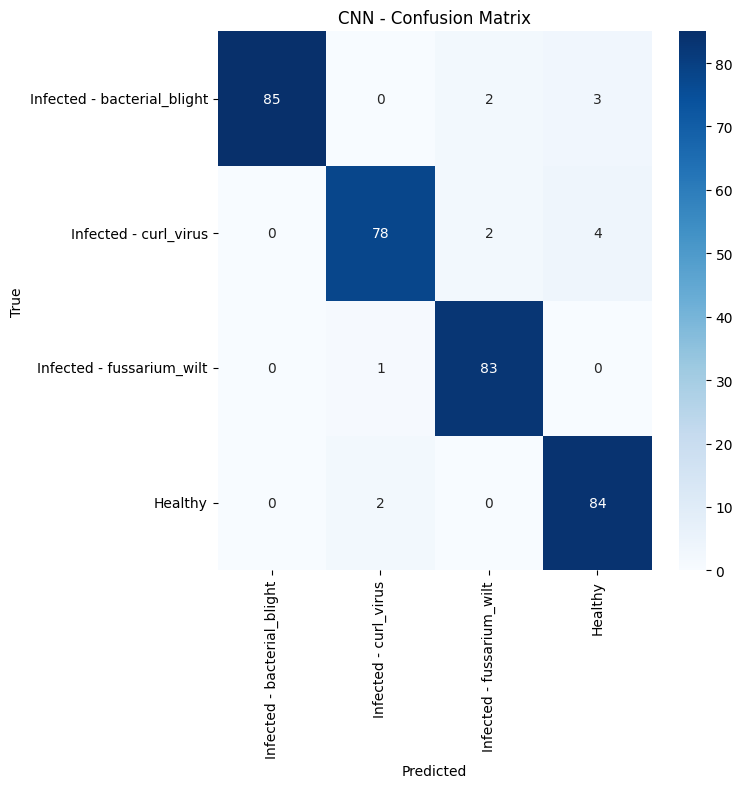

✅ Saved CNN confusion matrix & classification report


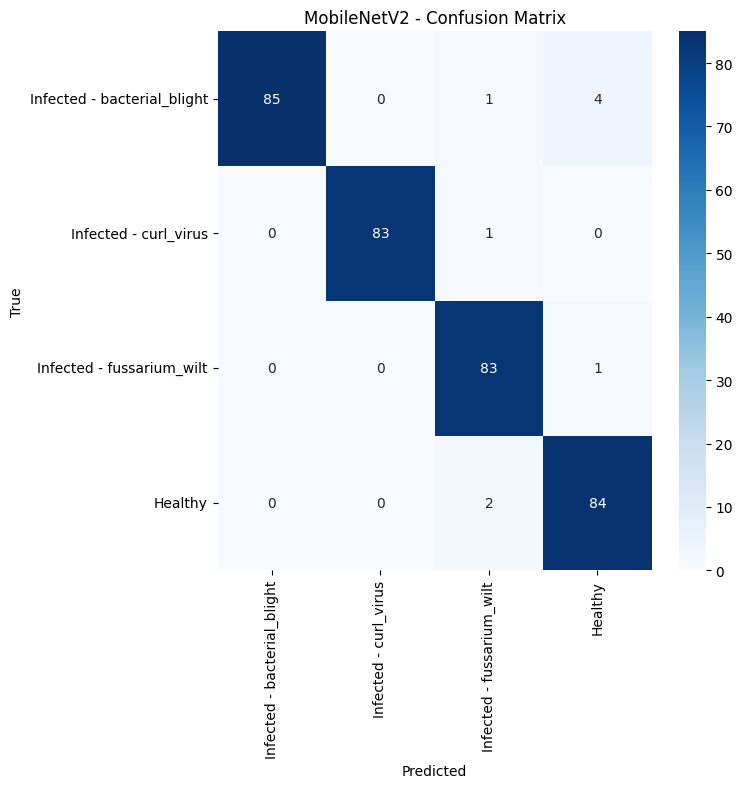

✅ Saved MobileNetV2 confusion matrix & classification report


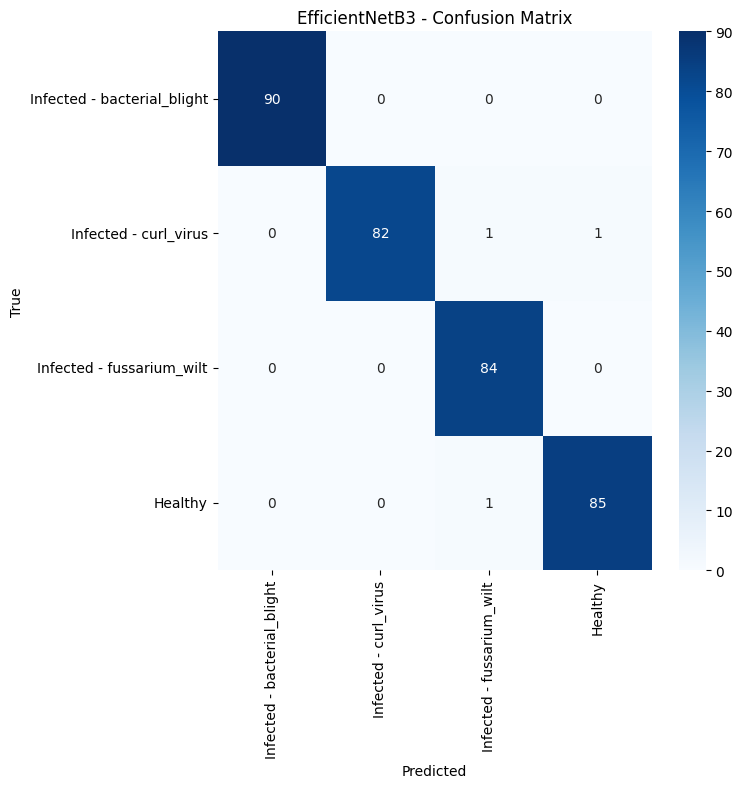

✅ Saved EfficientNetB3 confusion matrix & classification report


In [14]:
# =============================
# CELL 5: Confusion Matrix & Reports
# =============================

def format_label(label):
    return "Healthy" if label.lower() == "healthy" else f"Infected - {label}"

def evaluate_and_plot(model, name):
    preds = model.predict(val_gen, verbose=0)
    y_true = val_gen.classes
    y_pred = np.argmax(preds, axis=1)

    # Use formatted class labels
    formatted_classes = [format_label(c) for c in class_names]

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(7,7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=formatted_classes,
                yticklabels=formatted_classes)
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.savefig(f"{name}_confusion.png")
    plt.show()

    # Classification report with formatted labels
    report = classification_report(y_true, y_pred, target_names=formatted_classes)
    with open(f"{name}_report.txt", "w") as f:
        f.write(f"{name} - Classification Report\n\n")
        f.write(report)
    print(f"✅ Saved {name} confusion matrix & classification report")

# Run for all three models
evaluate_and_plot(cnn_model, "CNN")
evaluate_and_plot(mobilenet_model, "MobileNetV2")
evaluate_and_plot(eff_model, "EfficientNetB3")


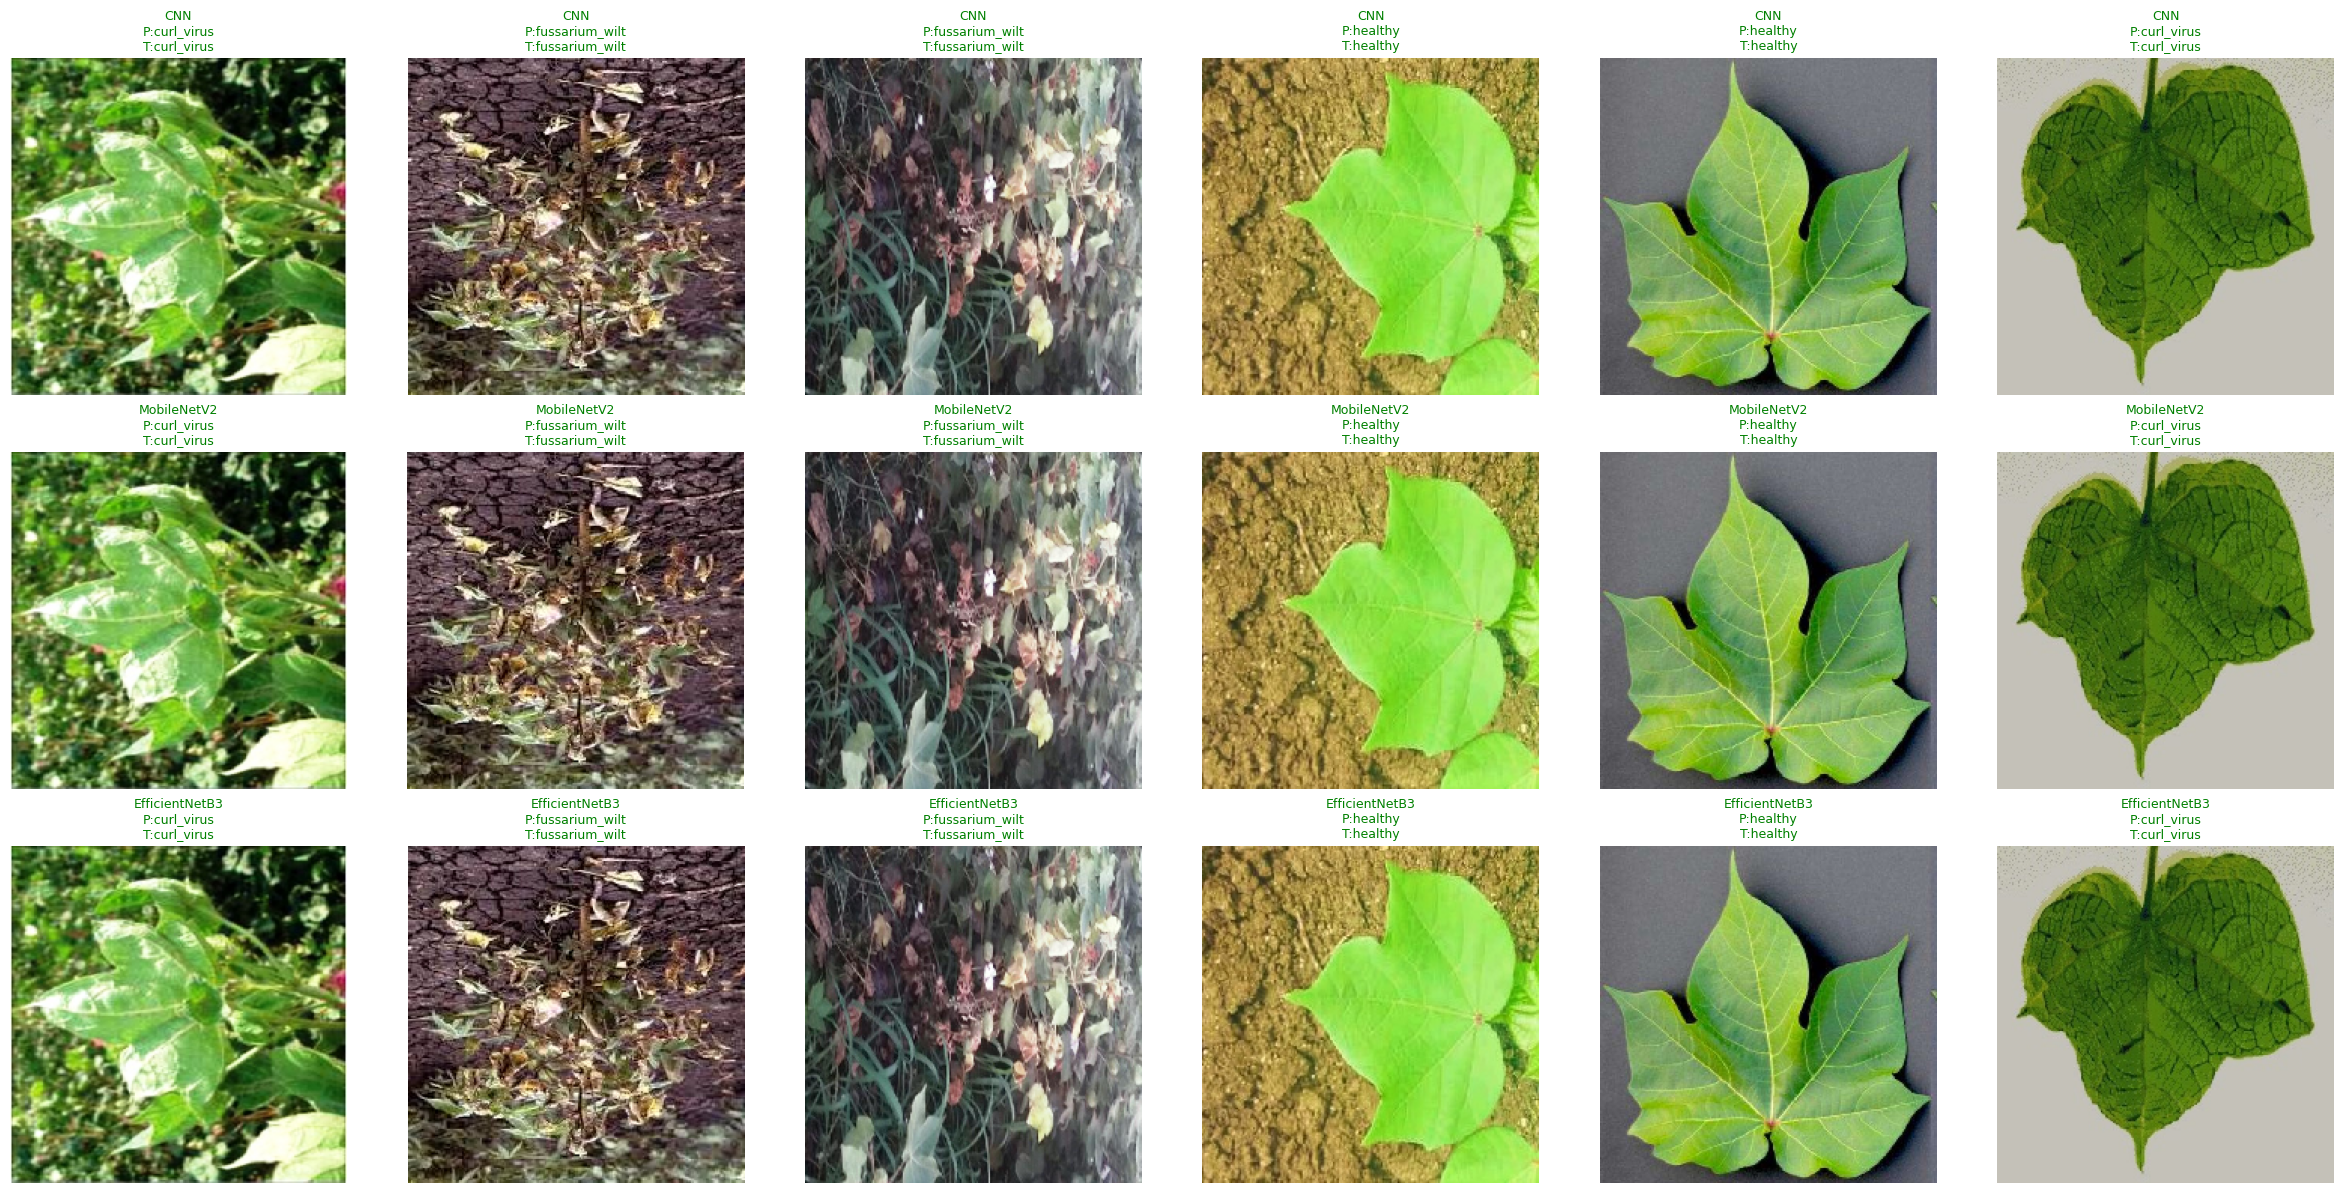

In [15]:
# =============================
# CELL 6: Predictions (Compare Models)
# =============================
def compare_predictions(models, model_names, n=6):
    sample_paths = random.sample(val_gen.filepaths, n)
    plt.figure(figsize=(4*n, 12))

    for row, (model, model_name) in enumerate(zip(models, model_names)):
        for col, path in enumerate(sample_paths):
            img = load_img(path, target_size=img_size)
            img_array = np.expand_dims(img_to_array(img)/255.0, axis=0)
            pred = np.argmax(model.predict(img_array, verbose=0), axis=1)[0]
            pred_label = class_names[pred]
            true_label = path.split("/")[-2]

            ax = plt.subplot(len(models), n, row*n + col + 1)
            plt.imshow(img)
            plt.axis("off")
            color = "green" if pred_label == true_label else "red"
            ax.set_title(f"{model_name}\nP:{pred_label}\nT:{true_label}", fontsize=9, color=color)

    plt.tight_layout()
    plt.savefig("predictions_comparison.png")  # ✅ save output
    plt.show()

compare_predictions(
    [cnn_model, mobilenet_model, eff_model],
    ["CNN", "MobileNetV2", "EfficientNetB3"], n=6
)


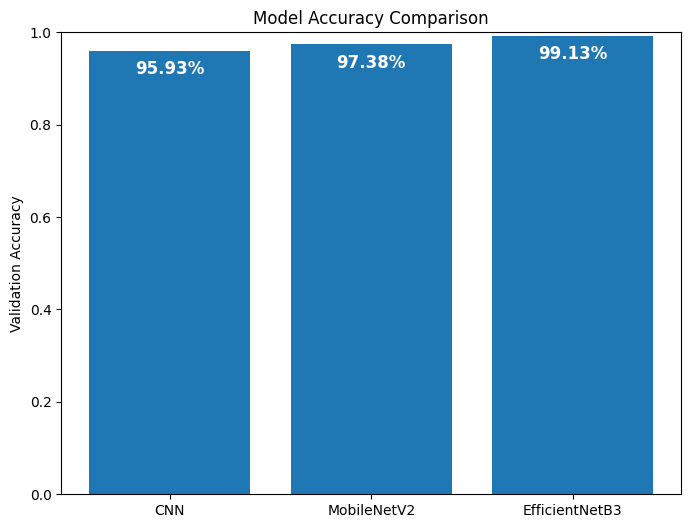

In [16]:
# =============================
# CELL 6B: Summary Accuracy Comparison
# =============================
def plot_model_accuracies(histories, model_names):
    final_acc = []
    for h in histories:
        # take the best val_accuracy seen during training
        best_acc = max(h.history['val_accuracy'])
        final_acc.append(best_acc)

    plt.figure(figsize=(8,6))
    bars = plt.bar(model_names, final_acc)
    plt.ylim(0,1)
    plt.ylabel("Validation Accuracy")
    plt.title("Model Accuracy Comparison")

    # annotate bars
    for bar, acc in zip(bars, final_acc):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height()-0.05,
                 f"{acc:.2%}", ha='center', color='white', fontsize=12, weight="bold")

    plt.savefig("model_accuracy_comparison.png")  # ✅ save plot
    plt.show()

plot_model_accuracies(
    [history_cnn, history_mobilenet_ft, history_eff_ft], 
    ["CNN", "MobileNetV2", "EfficientNetB3"]
)


In [17]:
# =============================
# CELL 7: Zip Results
# =============================
with zipfile.ZipFile("cotton_results.zip", "w") as zf:
    for f in os.listdir():
        if f.endswith(".png") or f.endswith(".txt"):
            zf.write(f)

print("✅ Results zipped as cotton_results.zip (includes confusion matrices, reports, predictions, and accuracy comparison)")


✅ Results zipped as cotton_results.zip (includes confusion matrices, reports, predictions, and accuracy comparison)
